In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
# Load in records_df

exp_name = 'AC02'

records_file_name = f'NEW_{exp_name}_hits.csv'

records_file_path = f'/Users/ishaharris/Projects/TCR/TCR-Isha/data/Processed/{records_file_name}'

records_df = pd.read_csv(records_file_path)
records_df

,patient_id,sequence,frequency,cmv_status
0,P00492,CASGPSNQPQHF,1.373438e-06,Positive
1,P00492,CASRDGRNYGYTF,6.867188e-07,Positive
2,P00492,CASSSANYGYTF,1.405027e-04,Positive
3,P00492,CASSLTGYGYTF,1.922813e-06,Positive
4,P00492,CASSLGQGQPQHF,2.334844e-06,Positive
...,...,...,...,...
3980,P00289,CASSLGQGQPQHF,8.377939e-06,Positive
3981,P00289,CASSFQGYTEAFF,2.345823e-05,Positive
3982,P00289,CASSLGETQYF,6.702351e-06,Positive
3983,P00289,CSVGTGGTNEKLFF,3.351176e-06,Positive


### Repertoire analysis

In [4]:
os.chdir("/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires")

metadata = pd.read_csv("/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires/Cohort01_whole_metadata.tsv", sep="\t") 

In [ ]:
# Set HLA of interest - change dynamically
hla = 'A*02'
hla_name = hla.replace('*','')

# Generate file names

os.chdir("/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires")

metadata = pd.read_csv("/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires/Cohort01_whole_metadata.tsv", sep="\t") 


metadata_annotat = metadata[metadata['sample_tags'].str.contains(f'HLA-{hla}',case=False, regex = False)]

metadata_annotat = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus|CMV\b', case=False, na=False)]
metadata_annotat = metadata_annotat.reset_index(drop=True)

#Extract pos and neg patient IDs
pos_names = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus \+|CMV \+\b', case=False, na=False)]
neg_names = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus -|CMV -\b', case=False, na=False)]

#Turn into file names
file_names = [name + '.tsv' for name in metadata_annotat['sample_name'].tolist()]
pos_names = [name + '.tsv' for name in pos_names['sample_name'].tolist()]
neg_names = [name + '.tsv' for name in neg_names['sample_name'].tolist()]


metadata_annotat.loc[10,'sample_tags']

print(f'Number of files with CMV and HLA annotation: {len(file_names)}')
print(f'Number of files with CMV +: {len(pos_names)}')
print(f'Number of files with CMV -: {len(neg_names)}')


NameError: name 'os' is not defined

In [8]:
max_freq_dict = {}

for file in file_names:
    print(f'Processing {file}')
    df = pd.read_csv(f'/Volumes/IshaVerbat/Isha/TCR/All_Emerson_Filtered/{file}', sep='\t')
    max_freq = df['frequency'].max()

    # Determine CMV status
    if file in pos_names:
        cmv_status = 'Positive'
    elif file in neg_names:
        cmv_status = 'Negative'
    else:
        cmv_status = 'Unknown'  # Fallback in case it's in neither list

    max_freq_dict[file] = {
        'max_freq': max_freq,
        'cmv_status': cmv_status
    }

    print(f'{file}: Max frequency = {max_freq}, CMV status = {cmv_status}')


Processing P00492.tsv
P00492.tsv: Max frequency = 0.0192223569259226, CMV status = Positive
Processing P00412.tsv
P00412.tsv: Max frequency = 0.01293258746563, CMV status = Positive
Processing P00416.tsv
P00416.tsv: Max frequency = 0.0066658079177115, CMV status = Negative
Processing P00037.tsv
P00037.tsv: Max frequency = 0.0025013820085666, CMV status = Negative
Processing P00346.tsv
P00346.tsv: Max frequency = 0.0404720345297871, CMV status = Positive
Processing P00353.tsv
P00353.tsv: Max frequency = 0.0112649787027592, CMV status = Negative
Processing P00278.tsv
P00278.tsv: Max frequency = 0.012225460337062, CMV status = Positive
Processing P00260.tsv
P00260.tsv: Max frequency = 0.0060595055951452, CMV status = Negative
Processing P00208.tsv
P00208.tsv: Max frequency = 0.0069431821017026, CMV status = Positive
Processing P00143.tsv
P00143.tsv: Max frequency = 0.0152711404563241, CMV status = Positive
Processing P00085.tsv
P00085.tsv: Max frequency = 0.128486697511556, CMV status = P

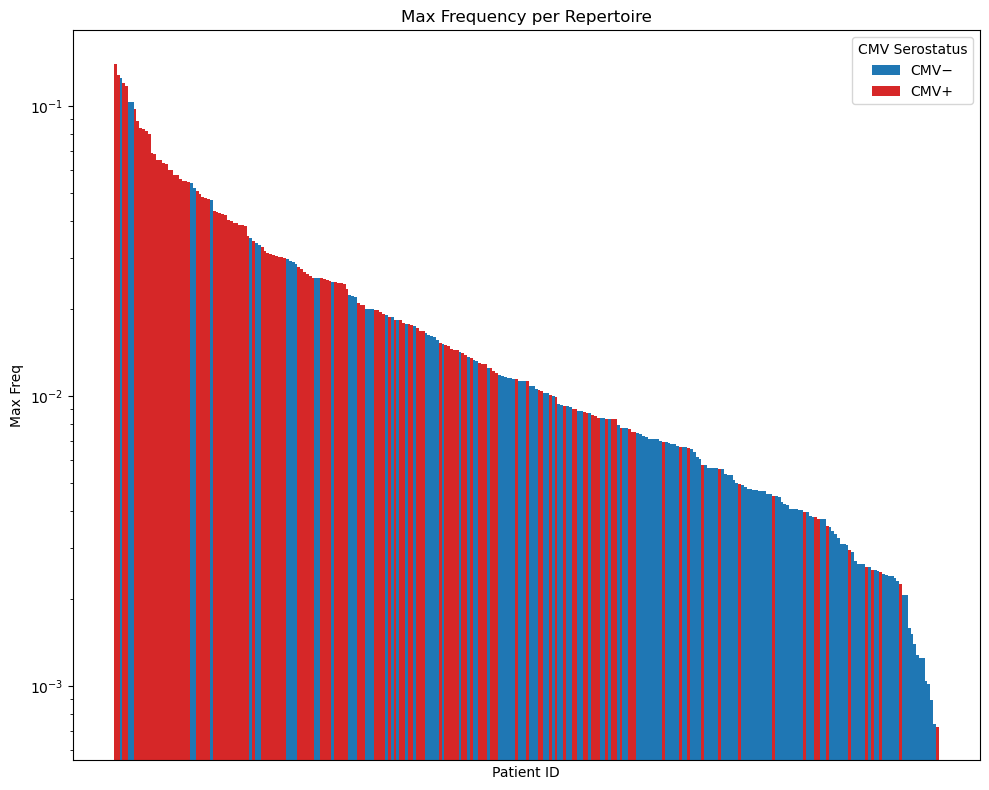

In [63]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colour map
color_map = {
    'Positive': 'tab:red',
    'Negative': 'tab:blue',}

legend_elements = [
    Patch(facecolor=color_map['Negative'], label='CMV−'),
    Patch(facecolor=color_map['Positive'], label='CMV+') # Optional
]

# Sort items by frequency
sorted_items = sorted(max_freq_dict.items(), key=lambda x: x[-1]['max_freq'], reverse=True)

# Extract sorted values
file_names = [k for k, v in sorted_items]
max_freqs = [v['max_freq'] for k, v in sorted_items]
colors = [color_map[v['cmv_status']] for k, v in sorted_items]

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(file_names, max_freqs, color=colors, width=1.0)
plt.xlabel('Patient ID')
plt.ylabel('Max Freq')
plt.xticks([])
plt.yscale('log')
plt.title('Max Frequency per Repertoire')
plt.legend(handles=legend_elements, title='CMV Serostatus')  # Add legend
plt.tight_layout()
plt.show()

### Make a new per_patient dataframe with cmv_burden as the sum of frequencies for that id

In [11]:
# Make a new per_patient where frequencies add

per_patient = (
    records_df
    .groupby(['patient_id', 'cmv_status'], as_index=False)
    .agg(cmv_burden=('frequency', 'sum'))
)


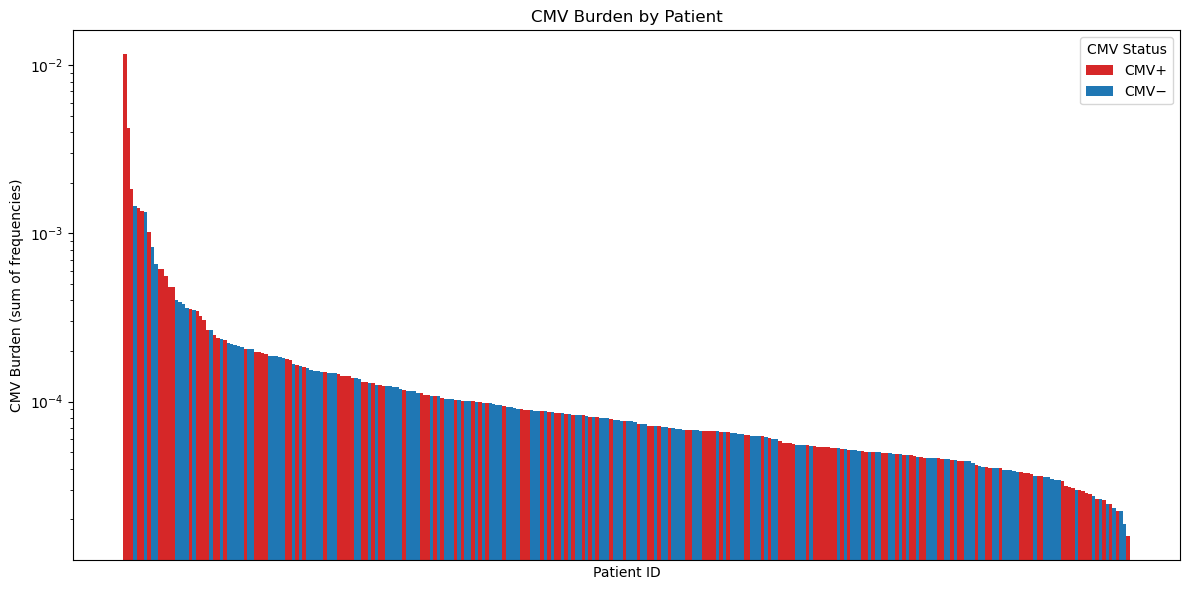

In [11]:
import matplotlib.pyplot as plt

# Sort by burden
per_patient_sorted = per_patient.sort_values(by='cmv_burden', ascending=False).reset_index(drop=True)

# Map CMV status to muted colors
color_map = {
    'Positive': 'tab:red',  # Muted blue
    'Negative': 'tab:blue'
}
bar_colors = per_patient_sorted['cmv_status'].map(color_map)

# Plotting
plt.figure(figsize=(12, 6))
x_positions = range(len(per_patient_sorted))
plt.bar(x_positions, per_patient_sorted['cmv_burden'], color=bar_colors, width=1.0)

# Add labels
plt.xticks(x_positions, per_patient_sorted['patient_id'], rotation=90)
plt.xlabel('Patient ID')
plt.ylabel('CMV Burden (sum of frequencies)')
plt.title('CMV Burden by Patient')
plt.yscale('log')
plt.xticks([])

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_map['Positive'], label='CMV+'),
    Patch(facecolor=color_map['Negative'], label='CMV−')
]
plt.legend(handles=legend_elements, title='CMV Status')

plt.tight_layout()
plt.show()


### Violin plots and box plots

/var/folders/ls/vwbn46k51_dbtpbp9vjn8kzh0000gq/T/ipykernel_14129/34001932.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cmv_status', y=feature, data=per_patient, inner='box', palette='muted')


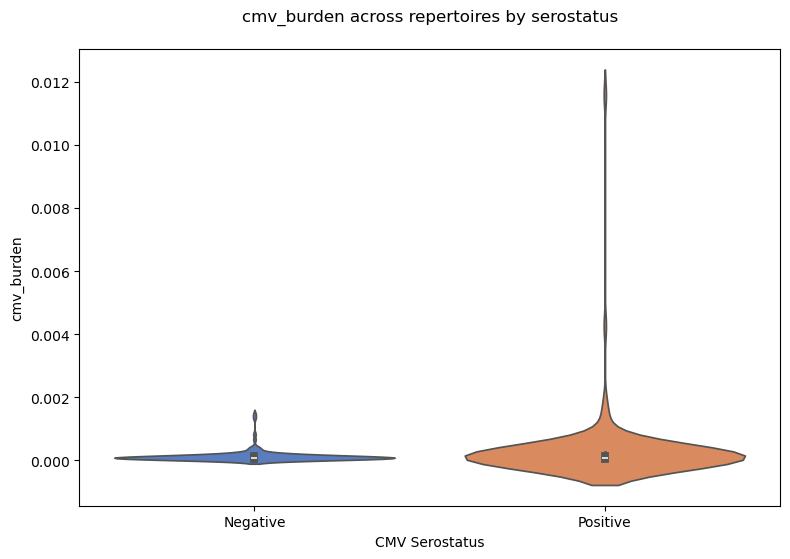

In [22]:
# Violin plot 
import seaborn as sns
import matplotlib.pyplot as plt

feature = 'cmv_burden'

plt.figure(figsize=(8, 6))
sns.violinplot(x='cmv_status', y=feature, data=per_patient, inner='box', palette='muted')

# Left-aligned title and subtitle
plt.title(f'{feature} across repertoires by serostatus', fontsize=12, loc='center', pad=20)
#plt.text(
   ## x=0, y=1.03,
    #s='Proportion of total repertoire reads that match high-confidence CMV-associated TCRs as identified by Immudex assay',
   # fontsize=7, ha='left', va='top', transform=plt.gca().transAxes
#)

plt.xlabel('CMV Serostatus')
plt.ylabel(f'{feature}')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserve space for title/subtitle
plt.show()


/var/folders/ls/vwbn46k51_dbtpbp9vjn8kzh0000gq/T/ipykernel_14129/365922542.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cmv_status', y=feature, data=per_patient, palette='muted')


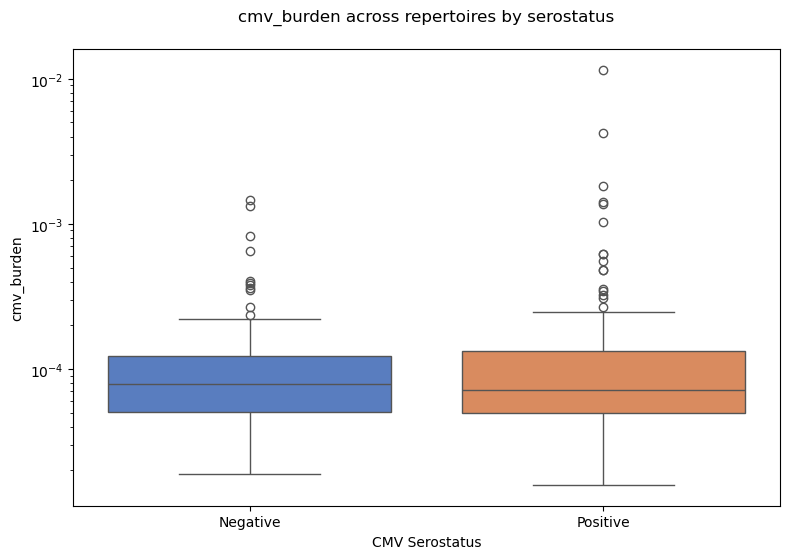

In [38]:
# strip plot 
import seaborn as sns
import matplotlib.pyplot as plt

feature = 'cmv_burden'

plt.figure(figsize=(8, 6))
sns.boxplot(x='cmv_status', y=feature, data=per_patient, palette='muted')

# Left-aligned title and subtitle
plt.title(f'{feature} across repertoires by serostatus', fontsize=12, loc='center', pad=20)
#plt.text(
   ## x=0, y=1.03,
    #s='Proportion of total repertoire reads that match high-confidence CMV-associated TCRs as identified by Immudex assay',
   # fontsize=7, ha='left', va='top', transform=plt.gca().transAxes
#)

plt.xlabel('CMV Serostatus')
plt.ylabel(f'{feature}')
plt.yscale('log')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserve space for title/subtitle
plt.show()


### Are the means significantly different?

In [28]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [32]:
from scipy.stats import ttest_ind

test_cols = ['cmv_burden']

for col in test_cols:
    stats = per_patient.groupby('cmv_status')[col].agg(['mean', 'std', 'median'])
    print(f"Stats for {col}:\n{stats}\n")
    
    # Get the two groups
    group1 = per_patient[per_patient['cmv_status'] == per_patient['cmv_status'].unique()[0]][col].dropna()
    group2 = per_patient[per_patient['cmv_status'] == per_patient['cmv_status'].unique()[1]][col].dropna()

    # Perform Welch's t-test
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

    print(f"Welch's t-test for {col}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}\n")


Stats for cmv_burden:
                mean       std    median
cmv_status                              
Negative    0.000124  0.000179  0.000079
Positive    0.000262  0.001070  0.000071

Welch's t-test for cmv_burden: t-statistic = -1.4913, p-value = 1.3811e-01



### Can i build a classifier based on cmv_burden?

In [26]:
max_freq_dict

{'P00492.tsv': {'max_freq': 0.0192223569259226, 'cmv_status': 'Positive'},
 'P00412.tsv': {'max_freq': 0.01293258746563, 'cmv_status': 'Positive'},
 'P00416.tsv': {'max_freq': 0.0066658079177115, 'cmv_status': 'Negative'},
 'P00037.tsv': {'max_freq': 0.0025013820085666, 'cmv_status': 'Negative'},
 'P00346.tsv': {'max_freq': 0.0404720345297871, 'cmv_status': 'Positive'},
 'P00353.tsv': {'max_freq': 0.0112649787027592, 'cmv_status': 'Negative'},
 'P00278.tsv': {'max_freq': 0.012225460337062, 'cmv_status': 'Positive'},
 'P00260.tsv': {'max_freq': 0.0060595055951452, 'cmv_status': 'Negative'},
 'P00208.tsv': {'max_freq': 0.0069431821017026, 'cmv_status': 'Positive'},
 'P00143.tsv': {'max_freq': 0.0152711404563241, 'cmv_status': 'Positive'},
 'P00085.tsv': {'max_freq': 0.128486697511556, 'cmv_status': 'Positive'},
 'P00625.tsv': {'max_freq': 0.0818808061661503, 'cmv_status': 'Positive'},
 'P00572.tsv': {'max_freq': 0.0301873345550804, 'cmv_status': 'Positive'},
 'P00496.tsv': {'max_freq': 0

In [17]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics        import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler


#Change var as desired
var = 'cmv_burden'

# Load data and Scaling
X = per_patient[[var]].values
y = per_patient['cmv_status'].map({'Negative': 0, 'Positive': 1}).values

#For max_freq
X = [[entry['max_freq']] for entry in max_freq_dict.values()]
y = [1 if entry['cmv_status'] == 'Positive' else 0 for entry in max_freq_dict.values()]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y)

# 2) Fit logistic
clf = LogisticRegression().fit(X_train, y_train)

# 3) Evaluate
probs = clf.predict_proba(X_test)[:,1]
auc   = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

print(f"AUC = {auc:.3f}")

AUC = 0.807


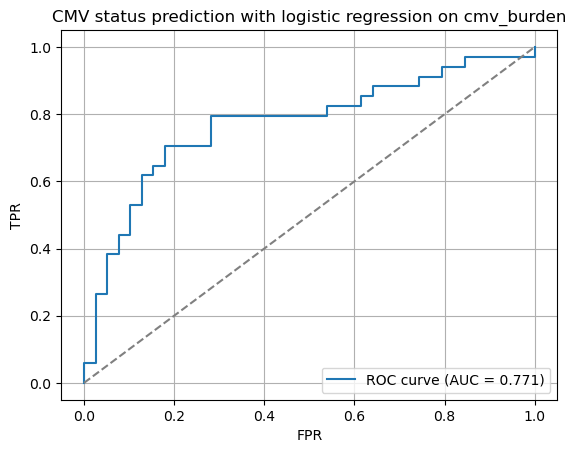

In [13]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line for reference
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'CMV status prediction with logistic regression on {var}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [29]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

probs_cv = cross_val_predict(LogisticRegression(), X_scaled, y, cv=cv, method='predict_proba')[:, 1]

# Compute ROC AUC
auc_cv = roc_auc_score(y, probs_cv)
fpr_cv, tpr_cv, _ = roc_curve(y, probs_cv)

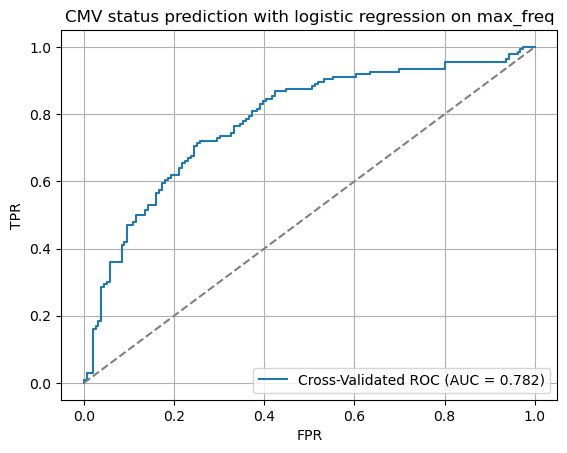

In [31]:
# Plot averaged ROC curve
import matplotlib.pyplot as plt

var='max_freq'

plt.figure()
plt.plot(fpr_cv, tpr_cv, label=f'Cross-Validated ROC (AUC = {auc_cv:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'CMV status prediction with logistic regression on {var}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()